# Kaggle BBC News Classification project
Rahul Cheeniyil

## Description
This project aims to classify various news articles in to the categories business, entertainment, politics, sport or tech based on article content. I will be comparing a couple supervised learning models to an unsupervised model to see how each performs on this task. The supervised models I'll train are a Support Vector Machine and a Miltinomial Naive bayes model. The unsupervised model I'll use is Non-Negative Matrix Factorization. Below are all the imports we'll need.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.linear_model import LogisticRegression

## EDA
The first step is to check out our data and see what it looks like. The data is fairly simple. There are 1490 columns broken up into 3 columns. Column 1 is an integer article ID used to uniquely identify each article. Column 2 contains the text contents of the article. Column 3 contains the correct classification of the article. Because there isn't any missing data, I don't need to do any data cleaning here before moving on to the preprocessing phase. As visualized in the histogram below, there are at least 250 of each article type which should give a pretty good sample size for training. The distribution of articles is also fairly even with the maximum difference in counts being 85.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


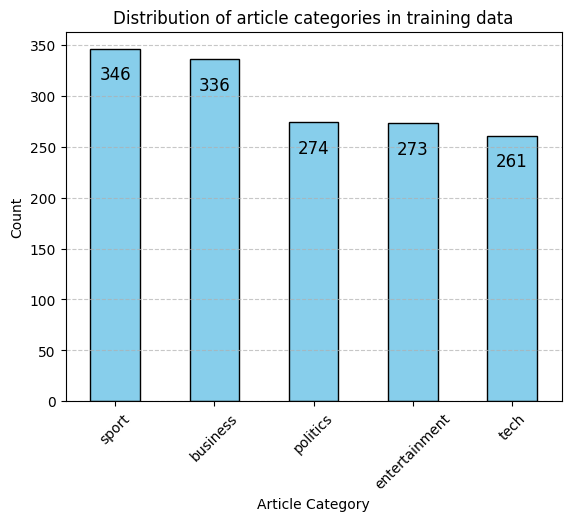

In [49]:
train_df = pd.read_csv('BBC News Train.csv')
print(train_df.info())
print(train_df.head())

category_counts = train_df['Category'].value_counts()

plt.figure()
bars = category_counts.plot(kind='bar',
                     color='skyblue',
                     edgecolor='black')
plt.xlabel('Article Category')
plt.ylabel('Count')
plt.title('Distribution of article categories in training data')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() - 30,
             f'{int(bar.get_height())}',
             ha='center', fontsize=12)

## Preprocessing
There are a few things to do before I can apply my target models to the data. First up, we'll need to encode category labels into numeric values. We'll then split the training data into train and validate sets. Finally, we'll need to actually encode the text content to enable training. To do this, I use Term Frequency-Inverse Document Frequency (TF-IDF). This encoding basically measures how frequently a word appears in a document and reduces the importance of words that appear frequently (e.g. grammatical components as articles or prepositions). I use a maximum feature number of 5,000 to limit our encoding of each article to a 5,000-dimensional space. I could optimize this number of features through some testing, but I think 5,000 is a good starting point to balance memory usage and the fact that we're only working with ~1500 documents. If I had a few million documents, I would probably use 50,000 dimensions and might need to build a faster computer.

In [30]:
# Encode our category labels into numerical values
label_encoder = LabelEncoder()
train_df['Category_encoded'] = label_encoder.fit_transform(train_df['Category'])
print(f' Labels are encoded as the following: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}')

# Split data into train and validate sets using a standard 80/20 split
X_train, X_val, y_train, y_val = train_test_split(train_df['Text'],
                                                  train_df['Category_encoded'],
                                                  test_size=0.2,
                                                  random_state=42)

# Encode text into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

 Labels are encoded as the following: {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


## Naive Bayes
We'll start with the Naive Bayes model. This model assumes that words in a document appear independently. It assigns a probability of a document of belonging to each class and chooses the most likely one. I'm not doing any hyperparameter tuning here, just using the base models.

In [31]:
# Train model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_val_tfidf)

# Evaluate model
nb_accuracy = accuracy_score(y_val, nb_preds)
nb_report = classification_report(y_val, nb_preds, target_names=label_encoder.classes_)
print(f'The Naive Bayes model has an accuracy of {round(nb_accuracy, 5)*100}%')
print("\n Performance report for the Naive Bayes model:")
print(nb_report)

The Naive Bayes model has an accuracy of 97.315%

 Performance report for the Naive Bayes model:
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        75
entertainment       1.00      1.00      1.00        46
     politics       0.93      0.95      0.94        56
        sport       0.98      1.00      0.99        63
         tech       0.98      0.95      0.96        58

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



## Support Vector Machine
A SVM model finds the optimal hyperplane that separates the different classes. Since text data is high dimensional (5,000 dimensions as I chose earlier), I'll use a linear kernel.

In [32]:
# Train model
svm_model = SVC(kernel="linear")
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_val_tfidf)

# Evaluate model
svm_accuracy = accuracy_score(y_val, svm_preds)
svm_report = classification_report(y_val, svm_preds, target_names=label_encoder.classes_)
print(f'The Support Vector Machine has an accuracy of {round(svm_accuracy, 5)*100}%')
print("\n Performance report for the Support Vector Machine model:")
print(svm_report)

The Support Vector Machine has an accuracy of 96.98%

 Performance report for the Support Vector Machine model:
               precision    recall  f1-score   support

     business       0.96      0.99      0.97        75
entertainment       0.96      0.98      0.97        46
     politics       0.93      0.95      0.94        56
        sport       1.00      1.00      1.00        63
         tech       1.00      0.93      0.96        58

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



## Non-Negative Matrix factorization
I start with NMF here, but NMF might not be the best choice of model. Given our large, mostly sparse matrices that are typical of text data vectorized with TF-IDF, NMF is pretty computationally expensive. Selecting even 500 components took about 50x longer to run on my machine than the SVM and still only correctly classified articles about 2/3 of the time. Accuracy would likely improve with additional components or additional iterations for convergence, but we can probably do better with a different model.

In [33]:
# Build model using 500 components
nmf = NMF(n_components=500, random_state=42)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
X_val_nmf = nmf.transform(X_val_tfidf)

# Train model
logreg_nmf = LogisticRegression(max_iter=1000)
logreg_nmf.fit(X_train_nmf, y_train)
nmf_preds = logreg_nmf.predict(X_val_nmf)

# Evaluate the model
nmf_accuracy = accuracy_score(y_val, nmf_preds)
nmf_report = classification_report(y_val, nmf_preds, target_names=label_encoder.classes_)

print(f'The NMF model has an accuracy of {round(nmf_accuracy, 5)*100}%')
print("\n Performance report for the NMF model:")
print(nmf_report)

The NMF model has an accuracy of 67.785%

 Performance report for the NMF model:
               precision    recall  f1-score   support

     business       0.80      0.87      0.83        75
entertainment       1.00      0.67      0.81        46
     politics       0.96      0.48      0.64        56
        sport       0.45      1.00      0.62        63
         tech       0.89      0.28      0.42        58

     accuracy                           0.68       298
    macro avg       0.82      0.66      0.66       298
 weighted avg       0.81      0.68      0.67       298



## Truncated SVD (Latent Semantic Analysis)
Instead of NMF, Truncated SVD might be more appropriate here. Truncated SVD should be more performant on our larger matrices here. Compared to NMF which should have a time complexity of O(NDkI), SVD should have a complexity of O(NDk) where N is the number of documents, D is the number of features, k is the number of latent dimensions, and I is the number of iterations for convergence. Additionally, because textual data is largely sparse, SVD will be more memory efficient because it doesn't need to convert to dense matrices like NMF does. From the results below, the SVD model performs both much faster than the NMF model and with much better accuracy around 96% which is more in line with the earlier supervised models.

In [34]:
# Build model also using 500 components
svd = TruncatedSVD(n_components=500, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)

# Train model
logreg_svd = LogisticRegression(max_iter=1000)
logreg_svd.fit(X_train_svd, y_train)
svd_preds = logreg_svd.predict(X_val_svd)

# Evaluate the model
svd_accuracy = accuracy_score(y_val, svd_preds)
svd_report = classification_report(y_val, svd_preds, target_names=label_encoder.classes_)

print(f'The SVD model has an accuracy of {round(svd_accuracy, 5)*100}%')
print("\n Performance report for the SVD model:")
print(svd_report)

The SVD model has an accuracy of 96.309%

 Performance report for the SVD model:
               precision    recall  f1-score   support

     business       0.96      0.97      0.97        75
entertainment       0.96      0.98      0.97        46
     politics       0.93      0.93      0.93        56
        sport       0.98      1.00      0.99        63
         tech       0.98      0.93      0.96        58

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298



## Results
Below are a few visualizations comparing and contrasting the results produced by the models I trained in this project. As seen in the accuracy bar chart, NMF is super low and generally not worth comparing. When originally generating heatmaps to compare precision, recall, and f1-score across article genres, I had included the NMF data, but due to poor results the color scale was super blown out. Because of this, I have chosen to omit NMF results from the heatmap plots.

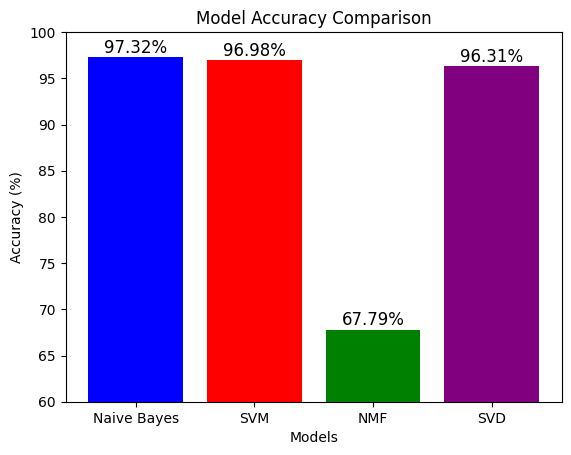

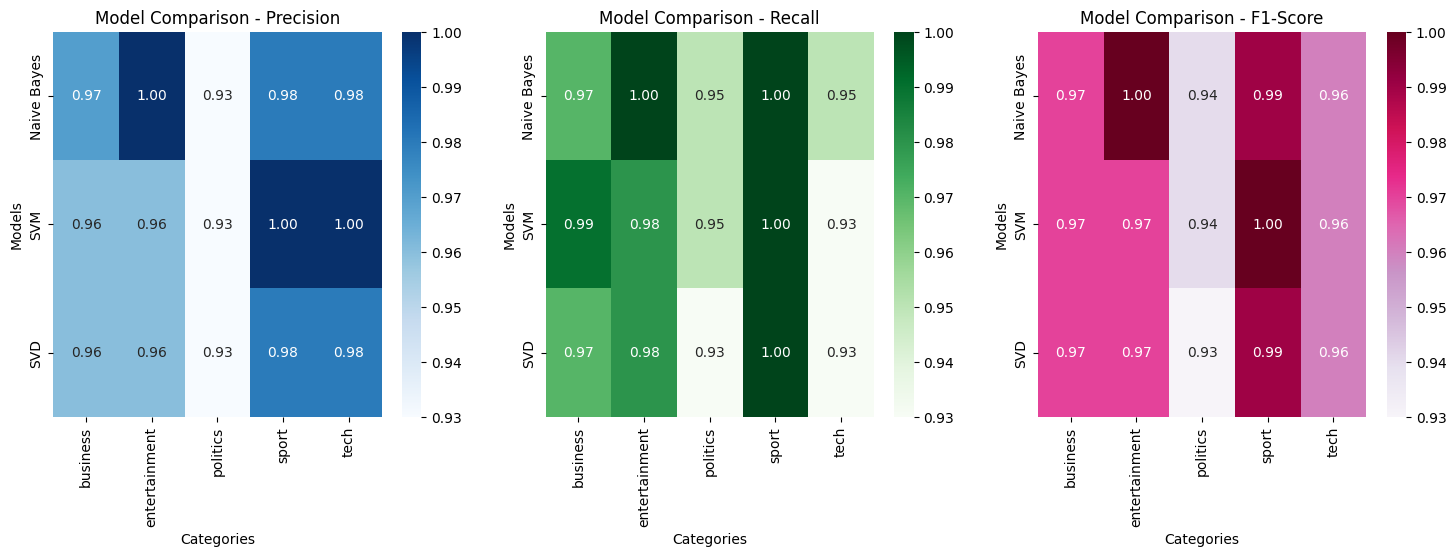

In [43]:
# Function to parse the report strings into dictionaries because I'm not manually typing out all of those results.
import re

def parse_classification_report(report_str: str) -> dict:
    report_dict = {}
    lines = report_str.strip().split('\n')

    # Regex pattern to match report item values
    pattern = re.compile(r'^\s*(\S+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)')

    for line in lines:
        if match := pattern.match(line):
            category, precision, recall, f1_score, support = match.groups()
            report_dict[category] = {
                "precision": float(precision),
                "recall": float(recall),
                "f1-score": float(f1_score),
                "support": int(support)
            }

    return report_dict

models = ["Naive Bayes", "SVM", "NMF", "SVD"]
accuracies = [acc*100 for acc in [nb_accuracy, svm_accuracy, nmf_accuracy, svd_accuracy]]

plt.figure()
plt.bar(models, accuracies, color=['blue', 'red', 'green', 'purple'])
plt.xlabel("Models"), plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(60, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f"{acc:.2f}%", ha = "center", fontsize=12)
plt.show()

# I'm excluding the NMF data from report result heatmaps as poor performance blows out the color scale preventing useful comparison of the better models
models = ["Naive Bayes", "SVM", "SVD"]
model_reports = [
    parse_classification_report(nb_report),
    parse_classification_report(svm_report),
    parse_classification_report(svd_report)
]

precision = [[model[cat]['precision'] for cat in label_encoder.classes_] for model in model_reports]
recall = [[model[cat]['recall'] for cat in label_encoder.classes_] for model in model_reports]
f1_score = [[model[cat]['f1-score'] for cat in label_encoder.classes_] for model in model_reports]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = [precision, recall, f1_score]
titles = ["Precision", "Recall", "F1-Score"]

colormaps = ["Blues", "Greens", "PuRd"]

for i, (metric, cmap) in enumerate(zip(metrics, colormaps)):
    ax = axes[i]
    sns.heatmap(metric,
                annot=True,
                fmt='.2f',
                cmap=cmap,
                xticklabels=label_encoder.classes_,
                yticklabels=models,
                ax=ax)
    ax.set_title(f'Model Comparison - {titles[i]}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Models')

plt.show()

## Discussion
Here I'll discuss performance of each model one by one talking about strengths and weaknesses of each
- Naive Bayes: Best overall performance
    - Accuracy: 97.32% (Highest among all models)
    - Strengths:
        - Performed consistently across all categories
        - Particularly good recall among Entertainment and Sports articles
        - Model works well with word frequency-based features due to model's assumption of independent word probabilities
    - Potential weaknesses:
        - May struggle with longer, more context-dependent texts due to assumption of independence
        - Can misclassify texts with ambiguous or overlapping terms as observed in the politics category.
- Support Vector Machine: Also very strong
    - Accuracy: 96.98% (just shy of Bayes model)
    - Strengths:
        - Most precise model for Sports and Tech genres
        - Best overall model specifically for Sports
        - Also works well with high-dimensional spaces when using a linear kernel
    - Potential Weaknesses:
        - Computationally heavier than Naive Bayes. Took a big longer to run
        - Scaling to larger datasets and higher dimensionality may require kernel optimization
- Non-Negative Matrix Factorization: Not good
    - Accuracy: 67.79%. About 25% worse than best performers
    - Major Weaknesses:
        - Non-negative constraint might limit expressiveness by making it harder to distinguish similar but opposing terms
        - TF-IDF encoding already provides good feature separation, so it likely struggles to capture topic structures
- Truncated SVD + Logistic Regression: Still good but short of supervised models
    - Accuracy: 96.31%. About 1% behind the leader
    - Strengths:
        - Designed to capture latent semantic relationships via dimensionality reduction
        - Performed pretty on-par with other models, but was brought down by Tech
    - Potential Weaknesses:
        - Reduces feature space complexity due to dimensionality reduction. Might lose information
        - Needs careful tuning of n_components to optimize results.


An interesting note: politics was consistently the worst performer for ALL models. This might have a few explanations. First, terminology may have overlap with business, technology, and sports articles. In vernacular English, we use a lot of idioms and similes to liken events to something more familiar. In politics, I've at least personally observed comparisons to sporting events fairly commonly, especially with elections being discussed in terms of horse racing. Additionally, political language can be more context-dependent with longer sentences and nuanced framing or implicit references. This would counter the assumption of independence of the Naive Bayes model as well as the frequency based encoding of TF-IDF. Perhaps using a more context-aware model for article encoding may have produced better results. A quick Google search suggests using a BERT model which may allow encoding of context.